# Importing packages

In [1]:
# Reading and saving data
import pandas as pd 

# Computations
import numpy as np 
import math

# Ploting 
import matplotlib.pyplot as plt
import pydot
import seaborn as sns
from IPython.display import Image

# Deep learning
import tensorflow as tf 

# Keras API 
from tensorflow import keras

# Deep learning 
from keras.models import Input, Model
from keras.layers import Concatenate, Dense, Masking, add, LSTM
from keras import losses

# Keras backend for custom loss functions
from keras import backend as K

# Custom function for batch creation 
from keras.utils import Sequence

# Setting default type
tf.keras.backend.set_floatx('float64')

# Reading the data 

The data is split into two parts in a single file: dataset1 and dataset2.
    
Which data is which can be identified from the column **DatasetID**.

In [2]:
d = pd.read_csv('data/multitasklearnig_task.csv')

In [3]:
print(f'Shape of the dataset: {d.shape}')

Shape of the dataset: (1000030, 10)


In [4]:
print(d.head())

   DatasetID    x1    x2    x3    x4    x5    x6     z   y1  y2
0          1 -1.84 -4.66  2.13 -1.32 -5.86 -4.69  2.89  0.0 NaN
1          1  1.31  0.16  2.94 -0.88  0.15 -3.69  1.25  1.0 NaN
2          1  0.60  4.23 -0.10  0.52  3.04 -0.23 -3.00  1.0 NaN
3          1  1.94  1.68  0.15 -3.16  0.12 -3.80  8.14  1.0 NaN
4          1  2.95  0.25  0.24 -0.47  3.10  0.69 -0.53  0.0 NaN


In [5]:
print(d.tail())

         DatasetID    x1    x2    x3    x4    x5    x6   z  y1         y2
1000025          2 -3.28 -1.20  0.50 -0.43 -2.13 -1.62 NaN NaN -19.905467
1000026          2  2.41  5.34 -3.96 -0.62  3.90 -4.47 NaN NaN   3.440164
1000027          2  2.74  5.80 -4.03 -0.82  6.98  4.53 NaN NaN  17.879392
1000028          2 -0.79 -4.31  3.73  0.83  0.23 -1.59 NaN NaN   0.764875
1000029          2  5.15  2.43 -1.69  1.46  3.36 -0.63 NaN NaN  19.181821


The number of observations for each dataset:

In [6]:
print(d.groupby('DatasetID').size())

DatasetID
1         30
2    1000000
dtype: int64


The first data set contains 30 rows while the second one contains 1 million rows.

## Creating the matrices for training

In [7]:
# Defining the masking values for deep learning
maskLogistic = -1
maskLinear = -991177

In [8]:
d4 = d[d['DatasetID']==2]
d5 = d[d['DatasetID']==1]
d6 = pd.concat([d4, d5])
d6.reset_index(inplace=True, drop=True)

In [9]:
features_x = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6']
X, Y1, Y2, Z = d6[features_x], d6['y1'], d6['y2'], d6['z']

In [10]:
X = np.asarray(X)
Y1 = np.asarray(Y1)
Y2 = np.asarray(Y2)
Z = np.asarray(Z)

In [11]:
# Preparing the data for linear input
Y2 = np.nan_to_num(Y2, nan=maskLinear)

# Preparing the data for logistic input
Y1 = np.nan_to_num(Y1, nan=maskLogistic)

# Auxilary variable
Z = np.nan_to_num(Z, nan=0)

## Defining the model

In [12]:
# Input shape
inputX = Input(shape=(X.shape[1], ), name="X_input")
inputZ = Input(shape=(1, ), name="Z_input")

# One neuron in the hidden layer with the linear activation function
linear = Dense(1, activation='linear', use_bias=False, name="X_linear")(inputX)

# Logistic path 
x_z = Concatenate(axis=1)([linear, inputZ])
logistic = Dense(1, activation='sigmoid', use_bias=False, name='X_logistic')(x_z)

# Combining everything together    
model = Model(inputs=[inputX, inputZ], outputs=[logistic, linear])

In [13]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X_input (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
X_linear (Dense)                (None, 1)            6           X_input[0][0]                    
__________________________________________________________________________________________________
Z_input (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 2)            0           X_linear[0][0]                   
                                                                 Z_input[0][0]         

Defining a deep learning model using the custom layer:

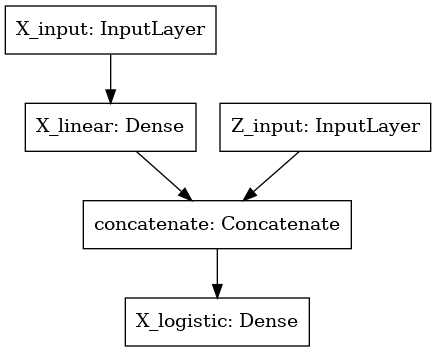

In [14]:
keras.utils.plot_model(model)

## Compiling the model and defining custom losses

In [15]:
sgd = keras.optimizers.SGD(learning_rate=0.001)

def masked_logistic_loss(maskv):
        
        def loss(y_true, y_pred):
            """
            Custom loss with masking for logistic regression
            """
            mask = K.cast(K.not_equal(y_true, maskv), K.floatx())
            return K.binary_crossentropy(y_true * mask, y_pred * mask) 
        
        return loss

def masked_linear_loss(maskv):

    def loss(y_true, y_pred):
        """
        Custom loss with masking for 
        """
        mask = K.cast(K.not_equal(y_true, maskv), K.floatx())
        return K.mean((y_true * mask - y_pred * mask) ** 2) 

    return loss

model.compile(
        loss={
            'X_logistic': masked_logistic_loss(maskLogistic),
            'X_linear': masked_linear_loss(maskLinear)
        }, 
        loss_weights=[0.9, 0.1],
        optimizer=sgd
    )

## Custom looping through the data

In [16]:
n_samples_logistic = d[d['DatasetID']==1].shape[0]
n_samples_linear = d[d['DatasetID']==2].shape[0]

In [17]:
print(f'Samples in logistic regression: {n_samples_logistic}')
print(f'Samples in linear regression: {n_samples_linear}')

Samples in logistic regression: 30
Samples in linear regression: 1000000


In [18]:
def create_batches(
    X, 
    Z, 
    Y1,
    Y2, 
    batch_size, 
    minority_class_n
):
    """
    A method to create a generator for deep learning training. 
    
    The logic is to split the whole dataset 
    into chunks of batch_size where the first *batch_size - minority_class_n* samples are from the majority class
    and the others are from the minority class. 
    """
    # Ensuring that the batch size is bigger than the minority class by at least one sample 
    if batch_size <= minority_class_n:
        print(f"Please define the batch size as atleast equal to {batch_size + 1}")
        yield {"X_input": [], "Z_input": []}, [[], []] 
    
    # Getting the whole range of indexes
    indexes = list(range(X.shape[0]))
    
    indexes_majority = indexes[:-minority_class_n] 
    indexes_minority = indexes[-minority_class_n:]

    new_index = []
    for i in range(0, len(indexes), batch_size - minority_class_n):
        new_index.append(indexes[i:i + batch_size - minority_class_n])
    
    # Adding the indexes of logistic regression observations to the indeces
    new_index = [x + indexes_minority for x in new_index]
    
    # Outputing the generator
    for ind in new_index:
        yield {"X_input": X[ind], "Z_input": Z[ind]}, [Y1[ind], Y2[ind]]

In [19]:
epochs = 1
for epoch in range(epochs):
    batches = create_batches(X, Z, Y1, Y2, batch_size=64, minority_class_n=n_samples_logistic)
    model.fit(batches)

29413/29413 [==============================] - 27s 934us/step - loss: 5.6651 - X_logistic_loss: 0.1114 - X_linear_loss: 55.6483


In [20]:
w = model.weights
print(f"""
Weights after training: 
\n
{w}
""")


Weights after training: 


[<tf.Variable 'X_linear/kernel:0' shape=(6, 1) dtype=float64, numpy=
array([[1.97429321],
       [2.01882893],
       [2.01978903],
       [2.05249081],
       [0.96968249],
       [2.0324138 ]])>, <tf.Variable 'X_logistic/kernel:0' shape=(2, 1) dtype=float64, numpy=
array([[0.31680463],
       [0.52038618]])>]



# Creating two separate models from the joint training

## Linear regression

In [21]:
inputX = Input(shape=(len(features_x), ), name="X_input")

# One neuron in the hidden layer with the linear activation function
linear = Dense(1, activation='linear', use_bias=False, name="X_linear")(inputX)

# Combining everything together    
model_linear = Model(inputs=inputX, outputs=linear)

In [22]:
model_linear.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X_input (InputLayer)         [(None, 6)]               0         
_________________________________________________________________
X_linear (Dense)             (None, 1)                 6         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________


In [23]:
model_linear.layers[1] = w[0].numpy()

## Logistic regression

In [24]:
# Input shape
inputLogisticRegression = Input(shape=(len(features_x) + 1, ), name="X_input")

# Last logistic neuron 
logistic = Dense(1, activation='sigmoid', use_bias=False, name='Sigmoid')(inputLogisticRegression)

# Defining the model, 
model_logistic = Model(inputLogisticRegression, logistic)

In [25]:
model_logistic.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X_input (InputLayer)         [(None, 7)]               0         
_________________________________________________________________
Sigmoid (Dense)              (None, 1)                 7         
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________


In [26]:
model_logistic.layers[1] = w[0].numpy() * w[1][0] + [w[1][1]] 

# Saving the model to objects

In [27]:
model_linear.save('linear_model.h5')
model_logistic.save('logistic_model.h5')